# Sample code for image search

This notebook contains the sample code for image search on CIFAR-10 test set using Deep Hashing trained model.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda
from chainer.datasets import cifar
from chainer import serializers
from chainer.iterators import SerialIterator

In [3]:
import sys
sys.path.append('../code')

In [4]:
from model import AlexNet, SSDH
from dataset import CIFAR10Datset

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'hourse', 'ship', 'truck']

## 1. Setup trained model

In [6]:
use_gpu = True

cnn = AlexNet()
model = SSDH(cnn, n_units=12)
model.train = False
serializers.load_npz('../output/unit12/model_32.npz', model)
if use_gpu:
    model.to_gpu()

## 2. Generate binary hash code using SSDH model

In [7]:
# prepare CIFAR-10 dataset
batchsize = 64

_, test = cifar.get_cifar10()
test_dataset = CIFAR10Datset(test)
test_iter = SerialIterator(test_dataset, batchsize,
                           repeat=False, shuffle=False)

In [8]:
# generate binary hash code using SSDH model
hash_data = []
for batch in test_iter:
    img = np.stack([d[0] for d in batch])
    if use_gpu:
        img = cuda.to_gpu(img)
    rtn = model(img)
    hash_data.append(cuda.to_cpu(rtn.data))

hash_data = np.concatenate(hash_data).astype(np.int32)
test_iter.finalize()

# check
print(hash_data.shape)

(10000, 12)


In [9]:
def display_image_and_hash_data(dataset, hash_data, idx):
    """Utility function to display image and binary hash code"""
    img = dataset[idx][0]
    plt.figure(figsize=(1, 1))
    plt.imshow(img.transpose(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print(hash_data[idx])

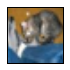

[0 0 1 1 0 0 1 1 0 0 1 1]


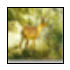

[1 0 1 1 0 1 1 0 0 0 1 1]


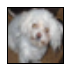

[0 1 1 0 0 1 1 1 0 0 1 0]


In [10]:
display_image_and_hash_data(test, hash_data, 0)
display_image_and_hash_data(test, hash_data, 500)
display_image_and_hash_data(test, hash_data, 1000)

## 3. Search similar image

In [11]:
def search_similar_image(hash_data, query_idx, top=10):
    """Search similar image by using hamming distance"""
    code_len = hash_data.shape[1]
    
    query_hash = hash_data[query_idx]
    print('Query: {}'.format("".join([str(int(i)) for i in query_hash])))
    
    hamming_distance = np.sum(query_hash != hash_data, axis=1) / float(code_len)
    hamming_distance[query_idx] = 1.  # set the maximum value for ignoring query image
    
    rank = np.argsort(hamming_distance)
    top_n = rank[:top]
    
    return top_n

In [12]:
def visualize_search_result(dataset, query_index, similar_indices):
    """Utility function to visualize search result"""
    n_vis = len(similar_indices) + 1
    
    fig, axs = plt.subplots(nrows=1, ncols=n_vis, figsize=(n_vis * 2, 2))
    data_indices = [query_index] + list(similar_indices)
    
    for i, idx in enumerate(data_indices):
        img, label = dataset[idx]
        axs[i].imshow(img.transpose(1, 2, 0))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        
        title = class_names[label]
        if i == 0:
            title += ' (query)'
        axs[i].set_title(title)
    plt.show()

Query: 001100110011


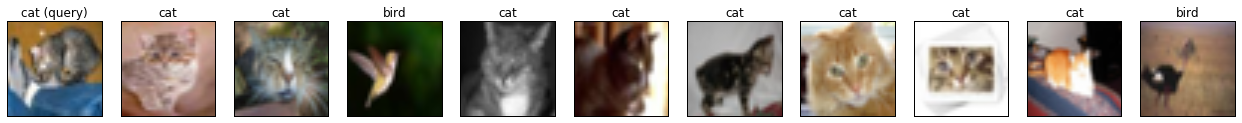

Query: 011001110010


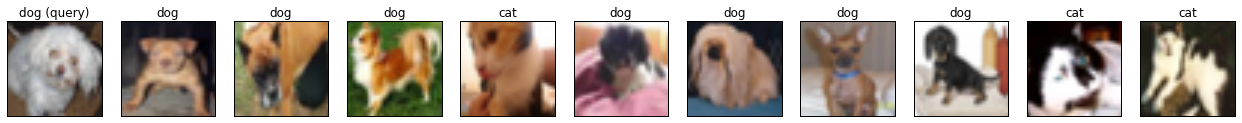

Query: 010011101110


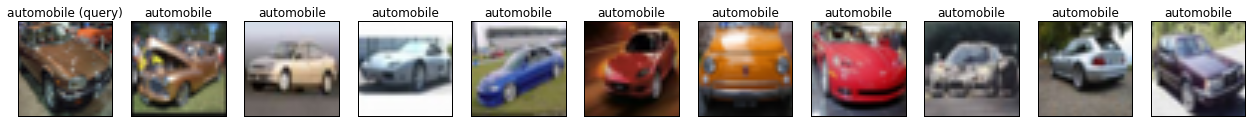

Query: 100101001101


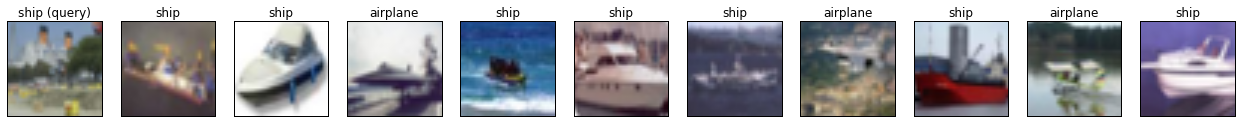

In [13]:
# search similar image
query_id_list = [0, 1000, 2000, 4000]  # 0-9999
for query_id in query_id_list:
    top_10 = search_similar_image(hash_data, query_id)
    visualize_search_result(test, query_id, top_10)